In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from util import random_matrix_generator, square_tensor_gen, inner_product
from simulation import Simulation, DimRedux, Simulations
import pickle
import matplotlib

Using numpy backend.


In [2]:
MARKER_LIST = ["d", "s", "x", "o","+","*","^"]
LINE_LIST = ['-', '--',':','-.','-.','-.','-.','-.']
COLOR_LIST = ['r', 'g','orange', 'violet', 'b','black','y']

In [3]:
def pairwise_dist(X): 
    d, n = X.shape
    dist_mat = np.zeros((n,n)) 
    for idx, x in np.ndenumerate(dist_mat): 
        # Note: the diagonal element is 0 (distance between the same point)
        if idx[0]  > idx[1]: 
            dist_mat[idx] = np.linalg.norm(X[:,idx[0]]- X[:,idx[1]])  
    return dist_mat

In [1]:
def mean_dist(dist_mats): 
    n, _ = (dist_mats[0]).shape
    err_mean = 0
    std_mean = 0
    for idx,x in np.ndenumerate(dist_mats[0]):  
        if idx[0] > idx[1]: 
            err_mean = err_mean + np.mean([dist_mat[idx] for dist_mat in dist_mats])/(n*(n-1)/2)
            std_mean = std_mean + np.std([dist_mat[idx] for dist_mat in dist_mats])/(n*(n-1)/2) 
    return err_mean, std_mean 

## We should change the mean to max in evaluating the pairwise distance preservation Below 

In [5]:
def sim_dist(X, ks, reduxs, num_runs = 100, seed = 1): 
    # We need X to have unit length for each data point
    np.random.seed(seed)
    results = []
    dist_mat0 = pairwise_dist(X) 
    d, n = X.shape
    for redux in reduxs: 
        err_means = []
        err_stds = []
        for k in ks: 
            # Create a new copy of dimension reduction map for modification
            [rm_typ, _, m, krao, krao_ms, vr, vr_num, sparse_factor, vr_typ] = redux.get_info()
            new_redux = DimRedux(rm_typ, k, m, krao, krao_ms, vr, vr_num, sparse_factor, vr_typ)
            # if new_redux.rm_typ in ['u','g','sgn']: 
                # Maintain the same storage for TRP-vr and RP
                # TRP case: Do nothing 
                # TRP-vr case
                # if krao & (krao_ms == []) & vr: 
                #    new_redux.vr_num = int(m/2/np.sqrt(m)) 
                # elif krao & (krao_ms != []) & vr: 
                #    new_redux.vr_num = int(m/np.sum(krao_ms))
            if new_redux.rm_typ in ['sp','sp0', 'sp1']: 
                # Maintain the same sparsity for RP, TRP, and TRP-vr  
                if krao & (krao_ms == []):
                    rm_typ = 'sp'
                    new_redux.sparse_factor = np.sqrt(new_redux.sparse_factor)
                    # if vr: 
                    #    new_redux.vr_num = int(m/2/np.sqrt(m))
                elif krao & (krao_ms != []) :
                    new_redux.rm_typ = 'sp'
                    new_redux.sparse_factor = np.power(new_redux.sparse_factor,1/len(new_redux.krao_ms))
                    # if vr: 
                      #   new_redux.vr_num = int(m/np.sum(krao_ms))
            errs = []
            for i in range(num_runs): 
                X_redux = new_redux.run(X)[0]
                dist_mat = pairwise_dist(X_redux)
                err = dist_mat/dist_mat0
                errs.append(err) 
            err_mean, err_std = mean_dist(errs)
            err_means = np.append(err_means,err_mean)
            err_stds = np.append(err_stds, err_std) 
        results.append((err_means, err_stds))
    return results

In [6]:
def plot_sim_dist(sims_result, dim_reduxs, ks, labels, title, name, fontsize = 18): 
        plt.figure(figsize=(6,5))
        plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
        plt.rc('text', usetex=True)
        for i in range(len(dim_reduxs)):
            plt.plot(ks, sims_result[i][0], label = labels[i], \
                marker = MARKER_LIST[i], ls ='-', color = COLOR_LIST[i])
            #plt.plot(ks, sims_result[i][1][0,:], ls = '--', color = COLOR_LIST[i] )
            #plt.plot(ks, sims_result[i][1][1,:], ls = '--', color = COLOR_LIST[i] )
            plt.plot(ks, sims_result[i][0]+2*sims_result[i][1], ls = '--', color = COLOR_LIST[i], marker = MARKER_LIST[i], fillstyle = 'none' )
            plt.plot(ks, sims_result[i][0]-2*sims_result[i][1], ls = '--', color = COLOR_LIST[i], marker = MARKER_LIST[i], fillstyle = 'none' )
        plt.axes().set_title(title)
        plt.axes().title.set_fontsize(fontsize)
        plt.axes().xaxis.label.set_fontsize(fontsize)
        plt.axes().yaxis.label.set_fontsize(fontsize)
        plt.rc('legend',fontsize = fontsize)
        plt.rc('xtick', labelsize = fontsize) 
        plt.rc('ytick', labelsize = fontsize) 
        plt.legend(loc = 'best')
        plt.xlabel('Reduced Dimension: k')
        plt.ylabel('Ratio of the Pairwise Distance')
        plt.tight_layout()
        plt.savefig('plots/'+name+'.pdf')
        plt.show()

# Simulation

## d = 2500

In [7]:
# Simulation for Random Projection (Length preservation)
k = 30    

ks = np.arange(5, 50, 2)
d = 2500 
n = 20
X = np.random.normal(0,1,(d, n))

redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True)
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'mean') 
redux8 = DimRedux('sp0',k, d, krao = True)
redux9 = DimRedux('sp0',k, d, krao = True, vr = True, vr_typ = 'mean')
redux10 = DimRedux('sp1',k, d, krao = True)
redux11 = DimRedux('sp1',k, d, krao = True, vr = True, vr_typ = 'mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11] 

In [8]:
#sim1 = sim_dist(X, ks, reduxs2)
#sim2 = sim_dist(X, ks, reduxs3) 
#sim3 = sim_dist(X, ks, reduxs4) 

In [9]:
[sim1,sim2,sim3] = pickle.load( open("data/dist_sim_2500.pickle", "rb" ) )

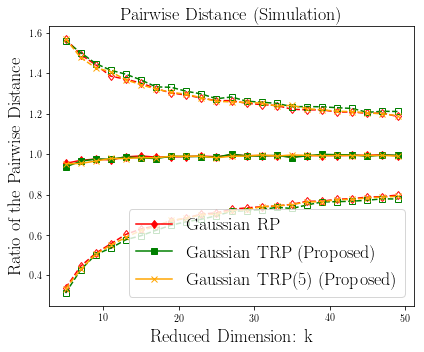

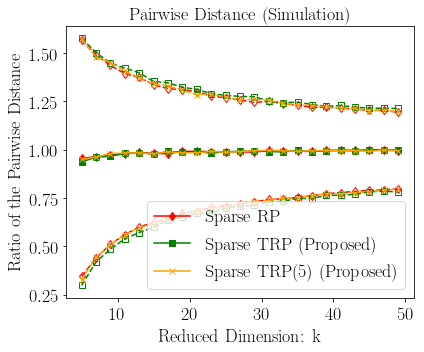

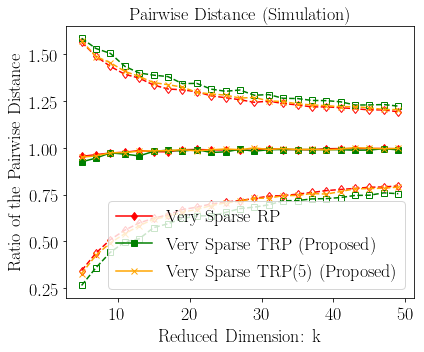

In [10]:
plot_sim_dist(sim1, reduxs2, ks, ["Gaussian RP", "Gaussian TRP (Proposed)", "Gaussian TRP(5) (Proposed)"], "Pairwise Distance (Simulation)", "dist_g_d"+str(d))
plot_sim_dist(sim2, reduxs3, ks, ['Sparse RP', 'Sparse TRP (Proposed)', 'Sparse TRP(5) (Proposed)'], 'Pairwise Distance (Simulation)', "dist_sp0_d"+str(d))
plot_sim_dist(sim3, reduxs4, ks, ['Very Sparse RP', 'Very Sparse TRP (Proposed)', 'Very Sparse TRP(5) (Proposed)'], "Pairwise Distance  (Simulation)", "dist_sp1_d"+str(d))

In [11]:
#pickle.dump([sim1,sim2,sim3], open("data/dist_sim_2500.pickle", "wb" ))

## d = 10000

In [12]:
# Simulation for Random Projection (Length preservation)
k = 30    

ks = np.arange(5, 50, 2)
d = 10000 
n = 20
X = np.random.normal(0,1,(d, n))

redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True)
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'mean') 
redux8 = DimRedux('sp0',k, d, krao = True)
redux9 = DimRedux('sp0',k, d, krao = True, vr = True, vr_typ = 'mean')
redux10 = DimRedux('sp1',k, d, krao = True)
redux11 = DimRedux('sp1',k, d, krao = True, vr = True, vr_typ = 'mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11] 

In [13]:
#sim1 = sim_dist(X, ks, reduxs2)
#sim2 = sim_dist(X, ks, reduxs3) 
#sim3 = sim_dist(X, ks, reduxs4) 

In [14]:
[sim1,sim2,sim3] = pickle.load( open("data/dist_sim_10000.pickle", "rb" ) )

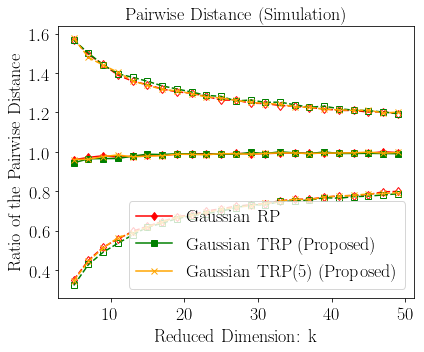

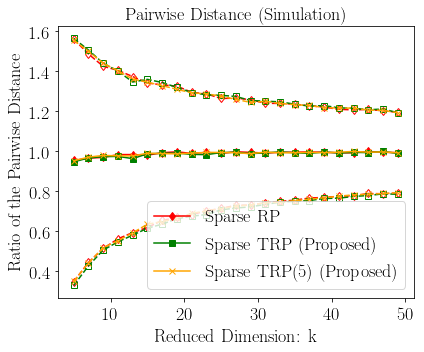

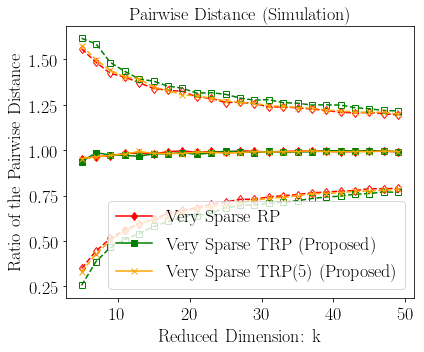

In [15]:
plot_sim_dist(sim1, reduxs2, ks, ["Gaussian RP", "Gaussian TRP (Proposed)", "Gaussian TRP(5) (Proposed)"], "Pairwise Distance (Simulation)", "dist_g_d"+str(d))
plot_sim_dist(sim2, reduxs3, ks, ['Sparse RP', 'Sparse TRP (Proposed)', 'Sparse TRP(5) (Proposed)'], 'Pairwise Distance (Simulation)', "dist_sp0_d"+str(d))
plot_sim_dist(sim3, reduxs4, ks, ['Very Sparse RP', 'Very Sparse TRP (Proposed)', 'Very Sparse TRP(5) (Proposed)'], "Pairwise Distance (Simulation)", "dist_sp1_d"+str(d))

In [16]:
#pickle.dump([sim1,sim2,sim3], open("data/dist_sim_10000.pickle", "wb" ))

## d = 40000

In [17]:
# Simulation for Random Projection (Length preservation)
k = 30    

ks = np.arange(5, 50, 2)
d = 40000 
n = 20
X = np.random.normal(0,1,(d, n))

redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True)
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'mean') 
redux8 = DimRedux('sp0',k, d, krao = True)
redux9 = DimRedux('sp0',k, d, krao = True, vr = True, vr_typ = 'mean')
redux10 = DimRedux('sp1',k, d, krao = True)
redux11 = DimRedux('sp1',k, d, krao = True, vr = True, vr_typ = 'mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11] 

In [18]:
#sim1 = sim_dist(X, ks, reduxs2)
#sim2 = sim_dist(X, ks, reduxs3) 
#sim3 = sim_dist(X, ks, reduxs4) 

In [19]:
[sim1,sim2,sim3] = pickle.load( open("data/dist_sim_40000.pickle", "rb" ) )

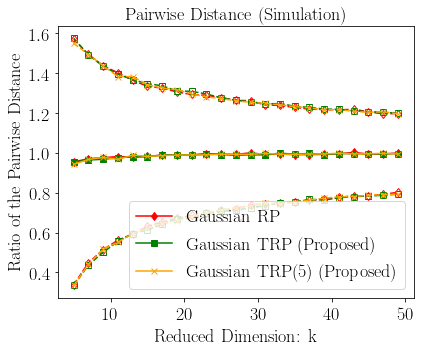

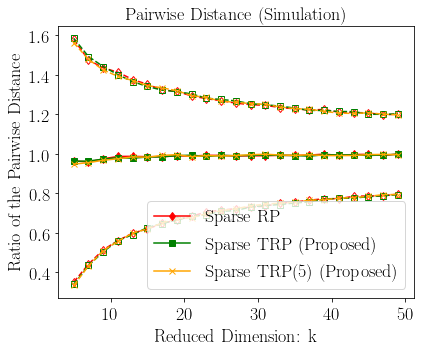

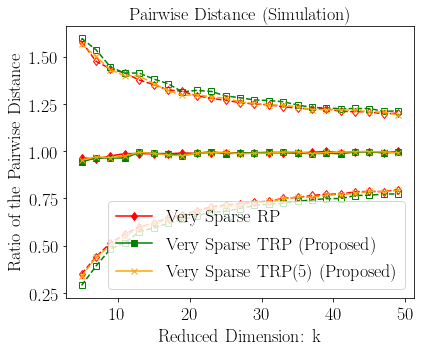

In [20]:
plot_sim_dist(sim1, reduxs2, ks, ["Gaussian RP", "Gaussian TRP (Proposed)", "Gaussian TRP(5) (Proposed)"], "Pairwise Distance (Simulation)", "dist_g_d"+str(d))
plot_sim_dist(sim2, reduxs3, ks, ['Sparse RP', 'Sparse TRP (Proposed)', 'Sparse TRP(5) (Proposed)'], 'Pairwise Distance (Simulation)', "dist_sp0_d"+str(d))
plot_sim_dist(sim3, reduxs4, ks, ['Very Sparse RP', 'Very Sparse TRP (Proposed)', 'Very Sparse TRP(5) (Proposed)'], "Pairwise Distance (Simulation)", "dist_sp1_d"+str(d))

In [21]:
#pickle.dump([sim1,sim2,sim3], open("data/dist_sim_40000.pickle", "wb" ))

# N = 3

In [22]:
# Simulation for Random Projection (Length preservation)
k = 30    
d = 125000
n = 20
ks = np.arange(5, 50, 2)
X = np.random.normal(0,1,(d, n))
krao_ms = np.repeat(50,3)

redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms) 
redux7 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'mean') 
redux8 = DimRedux('sp0',k, d, krao = True, krao_ms = krao_ms)
redux9 = DimRedux('sp0',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'mean')
redux10 = DimRedux('sp1',k, d, krao = True, krao_ms = krao_ms)
redux11 = DimRedux('sp1',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11]  

In [23]:
#sim1 = sim_dist(X, ks, reduxs2)
#sim2 = sim_dist(X, ks, reduxs3) 
#sim3 = sim_dist(X, ks, reduxs4) 

In [24]:
[sim1,sim2,sim3] = pickle.load( open("data/dist_sim_125000.pickle", "rb" ) )

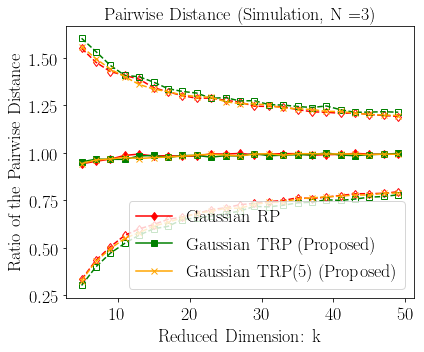

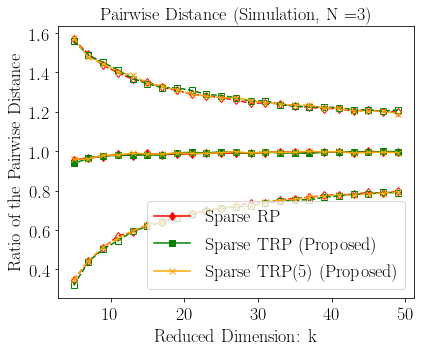

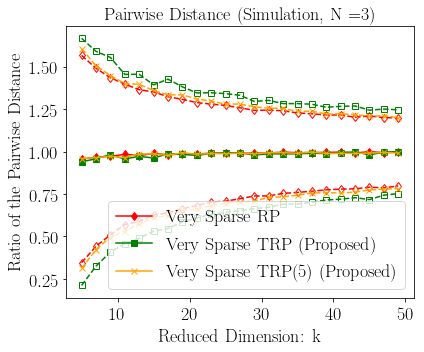

In [25]:
plot_sim_dist(sim1, reduxs2, ks, ["Gaussian RP", "Gaussian TRP (Proposed)", "Gaussian TRP(5) (Proposed)"], "Pairwise Distance (Simulation, N =3)", "dist_g_d"+str(d))
plot_sim_dist(sim2, reduxs3, ks, ['Sparse RP', 'Sparse TRP (Proposed)', 'Sparse TRP(5) (Proposed)'], 'Pairwise Distance (Simulation, N =3)', "dist_sp0_d"+str(d))
plot_sim_dist(sim3, reduxs4, ks, ['Very Sparse RP', 'Very Sparse TRP (Proposed)', 'Very Sparse TRP(5) (Proposed)'], "Pairwise Distance (Simulation, N =3)", "dist_sp1_d"+str(d))

In [26]:
#pickle.dump([sim1,sim2,sim3], open("data/dist_sim_125000.pickle", "wb" ))

# MNIST Data

In [27]:
import mnist
import scipy.misc
train_images = mnist.train_images()
train_x = train_images.reshape(train_images.shape[0], -1).T
n = 50 
d = 28*28
X = train_x[:,range(n)]
vnorm = np.linalg.norm(X, axis = 0, keepdims=True)  
X = X/vnorm


In [28]:
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True)
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'mean') 
redux8 = DimRedux('sp0',k, d, krao = True)
redux9 = DimRedux('sp0',k, d, krao = True, vr = True, vr_typ = 'mean')
redux10 = DimRedux('sp1',k, d, krao = True)
redux11 = DimRedux('sp1',k, d, krao = True, vr = True, vr_typ = 'mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11] 

In [29]:
#sim4 = sim_dist(X, ks, reduxs2) 
#sim5 = sim_dist(X, ks, reduxs3)
#sim6 = sim_dist(X, ks, reduxs4)

In [30]:
[sim4,sim5,sim6] = pickle.load( open("data/dist_mnist.pickle", "rb" ) )

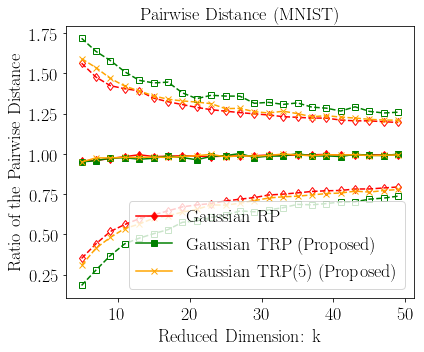

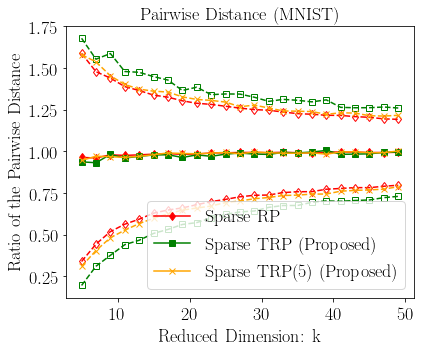

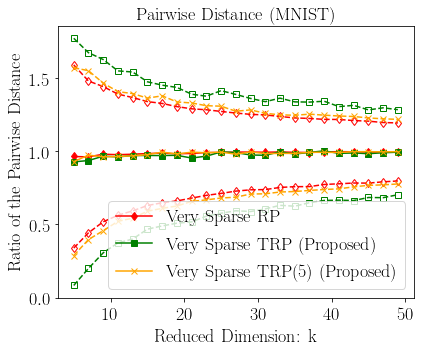

In [31]:
plot_sim_dist(sim4, reduxs2, ks, ["Gaussian RP", "Gaussian TRP (Proposed)", "Gaussian TRP(5) (Proposed)"], "Pairwise Distance (MNIST)", "dist_g_mnist")
plot_sim_dist(sim5, reduxs3, ks, ['Sparse RP', 'Sparse TRP (Proposed)', 'Sparse TRP(5) (Proposed)'], 'Pairwise Distance (MNIST)', 'dist_sp0_mnist')
plot_sim_dist(sim6, reduxs4, ks, ['Very Sparse RP', 'Very Sparse TRP (Proposed)', 'Very Sparse TRP(5) (Proposed)'], "Pairwise Distance (MNIST)", 'dist_sp1_mnist')

In [32]:
#pickle.dump([sim4,sim5,sim6], open("data/dist_mnist.pickle", "wb" ))